In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats import norm


In [140]:
def generate_demand(grid_size, num_nodes, demand_max):
    '''
    Generate random demand nodes within a grid.
    Args:
        grid_size (int): Size of the grid (grid_size x grid_size).
        num_nodes (int): Number of demand nodes to generate.
        demand_max (int): Maximum demand weight for each node.
    Returns:
        list of tuples: Each tuple contains (x, y, w) where (x, y) are coordinates and w is the demand weight.
    '''
    nodes = []
    used_coordinates = set()
    while len(nodes) < num_nodes:
        x, y = random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        if (x, y) not in used_coordinates:
            w = random.randint(1, demand_max)
            nodes.append((x, y, w))
            used_coordinates.add((x, y))
    return nodes

def visualize_demand_map(nodes, grid_size, demand_max):
    '''
    Visualize the demand nodes on a grid.
    Args:
        nodes (list of tuples): Each tuple contains (x, y, w) where (x, y) are coordinates and w is the demand weight.
        grid_size (int): Size of the grid (grid_size x grid_size).
        demand_max (int): Maximum demand weight for color normalization.
    '''
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1, grid_size)
    ax.set_ylim(-1, grid_size)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    norm = Normalize(vmin=0, vmax=demand_max)
    cmap = plt.cm.Blues

    for x, y, w in nodes:
        circle = plt.Circle((x, y), 1, color=cmap(norm(w)))
        ax.add_patch(circle)

    # Add a gradient legend
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Demand Size')

    plt.gca().set_aspect('equal', adjustable='box')

def visualize_demand_distribution(nodes):
    '''
    Visualize the distribution of demand weights.
    Args:
        nodes (list of tuples): Each tuple contains (x, y, w) where (x, y) are coordinates and w is the demand weight.
    '''
    fig_hist, ax_hist = plt.subplots(figsize=(6, 4))
    weights = [w for _, _, w in nodes]
    bin_size = int(np.ceil(np.sqrt(len(nodes))))
    ax_hist.hist(weights, bins=bin_size, color='blue', alpha=0.7, edgecolor='black')
    ax_hist.set_title('Distribution of Weights')
    ax_hist.set_xlabel('Weight (w)')
    ax_hist.set_ylabel('Frequency')

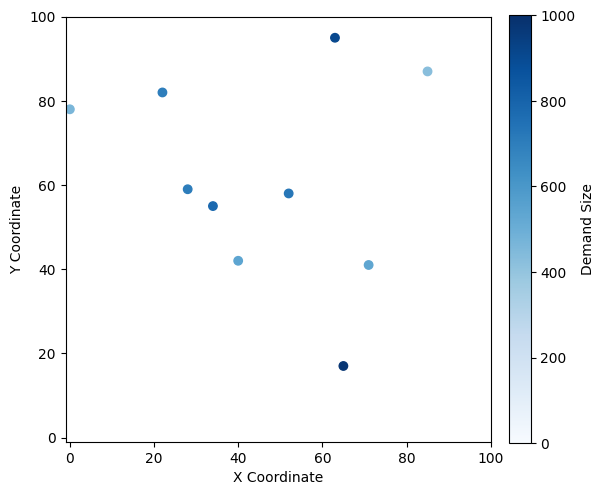

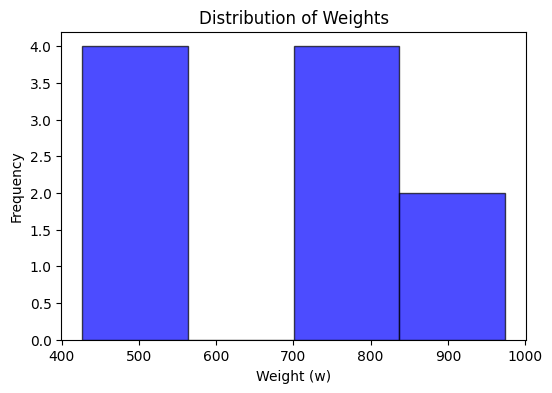

In [166]:
# Parameters
grid_size = 100
num_nodes = 10
demand_max = 1000

# Generate and visualize demand
nodes_demand = generate_demand(grid_size, num_nodes, demand_max)
visualize_demand_map(nodes_demand, grid_size, demand_max)
visualize_demand_distribution(nodes_demand)

In [167]:
def generate_supply_node(i, j, supply_quantity, nodes_demand):
    '''
    Generate a supply node at given coordinates with specified supply quantity.
    Args:
        i (int): X coordinate of the supply node.
        j (int): Y coordinate of the supply node.
        supply_quantity (int): Total supply quantity to be provided.
        nodes_demand (list of tuples): List of demand nodes (x, y, w).
    Returns:
        tuple: (i, j, supply_quantity) representing the supply node.
    '''
    node_supply = (i, j, supply_quantity)
    return node_supply

def compute_transport_cost(supply_node, demand_node, efficiency_coefficient):
    '''
    Compute transport cost from supply node to demand node.
    Args:
        supply_node (tuple): (x1, y1, supply) coordinates and supply quantity.
        demand_node (tuple): (x2, y2, demand) coordinates and demand quantity.
        efficiency_coefficient (float): Efficiency coefficient (0 < efficiency <= 1).
    Returns:
        float: Transport cost.
    '''
    x1, y1, supply = supply_node
    x2, y2, demand = demand_node
    distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    transport_cost = distance * demand * (1 - efficiency_coefficient)
    return transport_cost

# Generate a supply map given that transport is the only thing that matters
def generate_supply_map(nodes_demand, grid_size, demand_max, transport_efficiency):
    '''
    Generate a supply node and compute transport costs to demand nodes.
    Args:
        nodes_demand (list of tuples): List of demand nodes (x, y, w).
        grid_size (int): Size of the grid (grid_size x grid_size).
        demand_max (int): Maximum demand weight for each node.
        transport_efficiency (float): Efficiency coefficient (0 < efficiency <= 1).
    Returns:
        tuple: (supply_node, costs) where supply_node is (x, y, supply) and costs is a list of transport costs to each demand node.
    '''
    used_coordinates = set((x, y) for x, y, _ in nodes_demand)
    num_demand = len(nodes_demand)
    supply_needed = sum(w for _, _, w in nodes_demand)
    while True:
        i, j = random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        if (i, j) not in used_coordinates:
            node_supply = generate_supply_node(i, j, supply_needed, nodes_demand)
            break
    
    costs = []
    for x, y, w in nodes_demand:
        cost = compute_transport_cost(node_supply, (x, y, w), efficiency_coefficient=transport_efficiency)
        costs.append(cost)

    return node_supply, costs

# Optimize supply location to minimize total transport cost
def optimize_supply_location(nodes_demand, grid_size, demand_max, transport_efficiency, iterations=100):
    '''
    Optimize supply node location to minimize total transport cost.
    Args:
        nodes_demand (list of tuples): List of demand nodes (x, y, w).
        grid_size (int): Size of the grid (grid_size x grid_size).
        demand_max (int): Maximum demand weight for each node.
        transport_efficiency (float): Efficiency coefficient (0 < efficiency <= 1).
        iterations (int): Number of random supply locations to evaluate.
    Returns:
        tuple: (best_location, min_total_cost) where best_location is (x, y) and min_total_cost is the minimum transport cost found.
    '''
    best_location = None
    min_total_cost = float('inf')

    for _ in range(iterations):
        node_supply, costs = generate_supply_map(nodes_demand, grid_size, demand_max, transport_efficiency)
        total_cost = sum(costs)
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_location = (node_supply[0], node_supply[1])

    return best_location, min_total_cost

def visualize_supply_and_demand_map(supply_node, nodes_demand, grid_size, demand_max):
    '''
    Visualize the supply and demand nodes on a grid.
    Args:
        supply_node (tuple): (x, y) coordinates of the supply node.
        nodes_demand (list of tuples): Each tuple contains (x, y, w) where (x, y) are coordinates and w is the demand weight.
        grid_size (int): Size of the grid (grid_size x grid_size).
        demand_max (int): Maximum demand weight for color normalization.
    '''
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1, grid_size)
    ax.set_ylim(-1, grid_size)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    norm = Normalize(vmin=0, vmax=demand_max)
    cmap = plt.cm.Blues

    for x, y, w in nodes_demand:
        circle = plt.Circle((x, y), 1, color=cmap(norm(w)), alpha=0.5)
        ax.add_patch(circle)

    # Plot supply node
    supply_circle = plt.Circle((supply_node[0], supply_node[1]), 1.5, color='orange')
    ax.add_patch(supply_circle)

    # Add a gradient legend
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Demand Size')

    plt.gca().set_aspect('equal', adjustable='box')

Optimal Supply Location: (43, 57) with Minimum Total Transport Cost: 20053


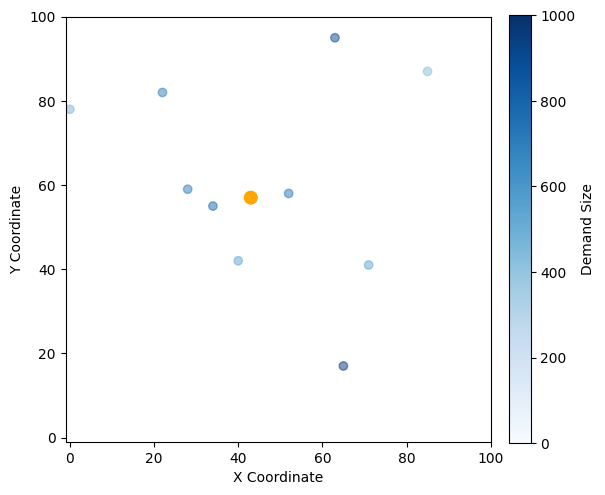

In [168]:
# Parameters
transport_efficiency = 0.9
iterations = 10000

best_location, min_cost = optimize_supply_location(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)
visualize_supply_and_demand_map((best_location[0], best_location[1]), nodes_demand, grid_size, demand_max)
print(f"Optimal Supply Location: {best_location} with Minimum Total Transport Cost: {int(np.round(min_cost))}")

In [169]:
# Let's say that people prefer to have the supply nodes far from them.
def compute_proximity_cost(supply_node, demand_node, grid_size):
    '''
    Compute proximity cost from supply node to demand node.
    Args:
        supply_node (tuple): (x1, y1, supply) coordinates and supply quantity.
        demand_node (tuple): (x2, y2, demand) coordinates and demand quantity.
    Returns:
        float: Proximity cost.'''
    x1, y1, supply = supply_node
    x2, y2, demand = demand_node
    distance = np.sqrt(((x1 - x2)**2 + (y1 - y2)**2) / grid_size)
    proximity_cost = supply / distance
    return proximity_cost

# Update the supply map generation to include proximity cost
def generate_supply_map_withpc(nodes_demand, grid_size, demand_max, transport_efficiency):
    '''
    Generate a supply node and compute total costs (transport + proximity) to demand nodes.
    Args:
        nodes_demand (list of tuples): List of demand nodes (x, y, w).
        grid_size (int): Size of the grid (grid_size x grid_size).
        demand_max (int): Maximum demand weight for each node.
        transport_efficiency (float): Efficiency coefficient (0 < efficiency <= 1).
    Returns:
        tuple: (supply_node, costs) where supply_node is (x, y, supply) and costs is a list of total costs to each demand node.
    '''
    used_coordinates = set((x, y) for x, y, _ in nodes_demand)
    num_demand = len(nodes_demand)
    supply_needed = sum(w for _, _, w in nodes_demand)
    while True:
        i, j = random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        if (i, j) not in used_coordinates:
            node_supply = generate_supply_node(i, j, supply_needed, nodes_demand)
            break
    
    proximity_costs = []
    transport_costs = []
    for x, y, w in nodes_demand:
        transport_cost = compute_transport_cost(node_supply, (x, y, w), efficiency_coefficient=transport_efficiency)
        proximity_cost = compute_proximity_cost(node_supply, (x, y, w), grid_size)
        proximity_costs.append(proximity_cost)
        transport_costs.append(transport_cost)

    return node_supply, transport_costs, proximity_costs

def optimize_supply_location_withpc(nodes_demand, grid_size, demand_max, transport_efficiency, iterations=100):
    '''
    Optimize supply node location to minimize total transport cost.
    Args:
        nodes_demand (list of tuples): List of demand nodes (x, y, w).
        grid_size (int): Size of the grid (grid_size x grid_size).
        demand_max (int): Maximum demand weight for each node.
        transport_efficiency (float): Efficiency coefficient (0 < efficiency <= 1).
        iterations (int): Number of random supply locations to evaluate.
    Returns:
        tuple: (best_location, min_total_cost) where best_location is (x, y) and min_total_cost is the minimum transport cost found.
    '''
    best_location = None
    min_total_cost = float('inf')
    min_transport_cost = float('inf')

    for _ in range(iterations):
        node_supply, transport_costs, proximity_costs = generate_supply_map_withpc(nodes_demand, grid_size, demand_max, transport_efficiency)
        total_cost = sum(transport_costs) + sum(proximity_costs)
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_location = (node_supply[0], node_supply[1])
            min_transport_cost = sum(transport_costs)

    return best_location, min_total_cost, min_transport_cost

Optimal Supply Location: (49, 77) with Minimum Total Transport Cost: 23540


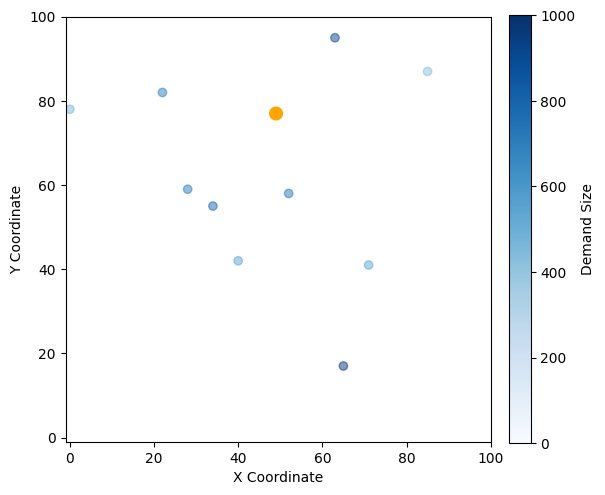

In [170]:
best_location, min_cost, min_transport_cost = optimize_supply_location_withpc(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)
visualize_supply_and_demand_map((best_location[0], best_location[1]), nodes_demand, grid_size, demand_max)
print(f"Optimal Supply Location: {best_location} with Minimum Total Transport Cost: {int(np.round(min_transport_cost))}")

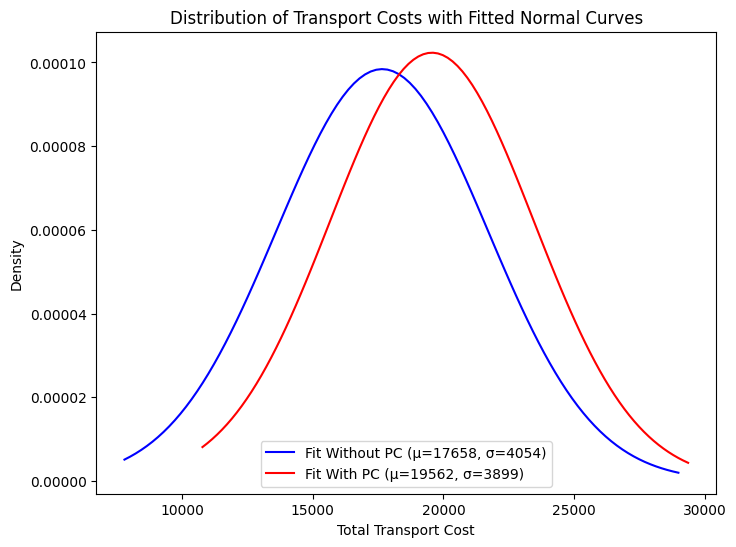

In [172]:
transport_costs_no_pc = []
transport_costs_with_pc = []
iterations = 500

for _ in range(200):

    nodes_demand = generate_demand(grid_size, num_nodes, demand_max)

    # Generate supply node and compute transport costs without proximity cost
    _, costs_no_pc = optimize_supply_location(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)

    _, _, costs_with_pc = optimize_supply_location_withpc(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)

    transport_costs_no_pc.append(costs_no_pc)
    transport_costs_with_pc.append(costs_with_pc)

# Fit normal distribution to the data
mean_no_pc, std_no_pc = norm.fit(transport_costs_no_pc)
mean_with_pc, std_with_pc = norm.fit(transport_costs_with_pc)

# Visualize the distributions with fitted curves
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the fitted normal distribution curves
x_no_pc = np.linspace(min(transport_costs_no_pc), max(transport_costs_no_pc), 100)
x_with_pc = np.linspace(min(transport_costs_with_pc), max(transport_costs_with_pc), 100)
pdf_no_pc = norm.pdf(x_no_pc, mean_no_pc, std_no_pc)
pdf_with_pc = norm.pdf(x_with_pc, mean_with_pc, std_with_pc)
ax.plot(x_no_pc, pdf_no_pc, 'b-', label=f'Fit Without PC (μ={mean_no_pc:.0f}, σ={std_no_pc:.0f})')
ax.plot(x_with_pc, pdf_with_pc, 'r-', label=f'Fit With PC (μ={mean_with_pc:.0f}, σ={std_with_pc:.0f})')

# Add titles and labels
ax.set_title('Distribution of Transport Costs with Fitted Normal Curves')
ax.set_xlabel('Total Transport Cost')
ax.set_ylabel('Density')
ax.legend()
plt.show()

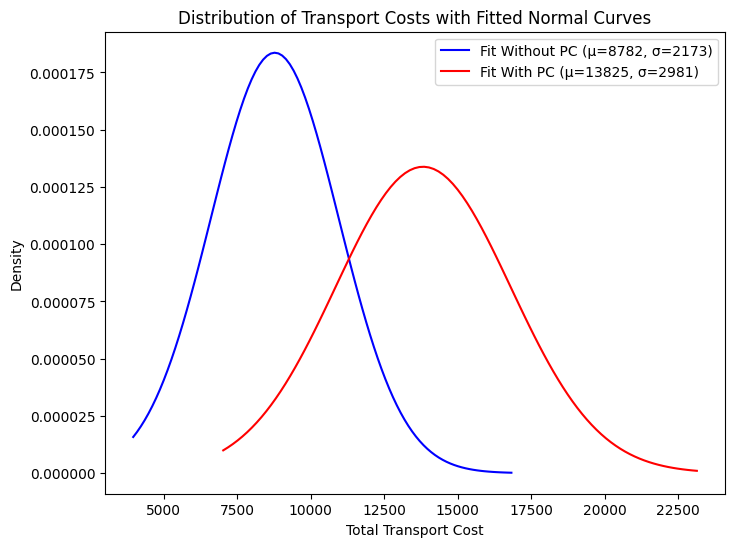

In [174]:
# Parameters
grid_size = 50
num_nodes = 10
demand_max = 1000
transport_efficiency = 0.9
iterations = 500

# Generate and visualize demand
transport_costs_no_pc = []
transport_costs_with_pc = []

for _ in range(200):

    nodes_demand = generate_demand(grid_size, num_nodes, demand_max)

    # Generate supply node and compute transport costs without proximity cost
    _, costs_no_pc = optimize_supply_location(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)

    _, _, costs_with_pc = optimize_supply_location_withpc(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)

    transport_costs_no_pc.append(costs_no_pc)
    transport_costs_with_pc.append(costs_with_pc)

# Fit normal distribution to the data
mean_no_pc, std_no_pc = norm.fit(transport_costs_no_pc)
mean_with_pc, std_with_pc = norm.fit(transport_costs_with_pc)

# Visualize the distributions with fitted curves
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the fitted normal distribution curves
x_no_pc = np.linspace(min(transport_costs_no_pc), max(transport_costs_no_pc), 100)
x_with_pc = np.linspace(min(transport_costs_with_pc), max(transport_costs_with_pc), 100)
pdf_no_pc = norm.pdf(x_no_pc, mean_no_pc, std_no_pc)
pdf_with_pc = norm.pdf(x_with_pc, mean_with_pc, std_with_pc)
ax.plot(x_no_pc, pdf_no_pc, 'b-', label=f'Fit Without PC (μ={mean_no_pc:.0f}, σ={std_no_pc:.0f})')
ax.plot(x_with_pc, pdf_with_pc, 'r-', label=f'Fit With PC (μ={mean_with_pc:.0f}, σ={std_with_pc:.0f})')

# Add titles and labels
ax.set_title('Distribution of Transport Costs with Fitted Normal Curves')
ax.set_xlabel('Total Transport Cost')
ax.set_ylabel('Density')
ax.legend()
plt.show()

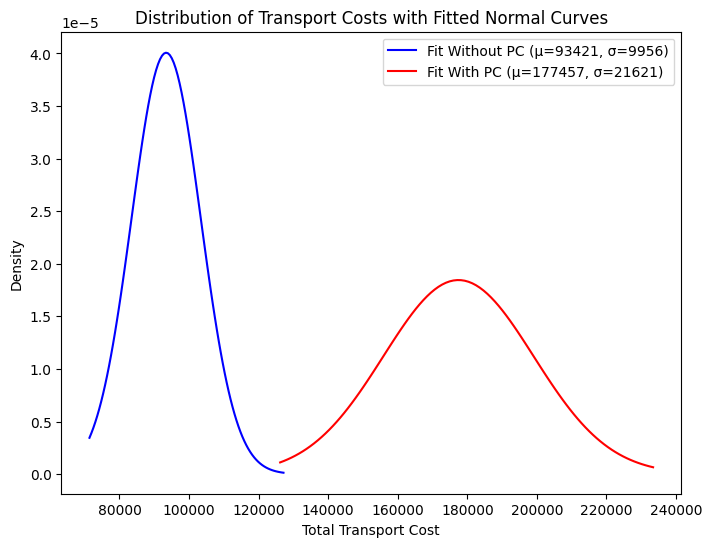

In [176]:
# Parameters
grid_size = 100
num_nodes = 50
demand_max = 1000
transport_efficiency = 0.9
iterations = 500

# Generate and visualize demand
transport_costs_no_pc = []
transport_costs_with_pc = []

for _ in range(200):

    nodes_demand = generate_demand(grid_size, num_nodes, demand_max)

    # Generate supply node and compute transport costs without proximity cost
    _, costs_no_pc = optimize_supply_location(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)

    _, _, costs_with_pc = optimize_supply_location_withpc(nodes_demand, grid_size, demand_max, transport_efficiency, iterations)

    transport_costs_no_pc.append(costs_no_pc)
    transport_costs_with_pc.append(costs_with_pc)

# Fit normal distribution to the data
mean_no_pc, std_no_pc = norm.fit(transport_costs_no_pc)
mean_with_pc, std_with_pc = norm.fit(transport_costs_with_pc)

# Visualize the distributions with fitted curves
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the fitted normal distribution curves
x_no_pc = np.linspace(min(transport_costs_no_pc), max(transport_costs_no_pc), 100)
x_with_pc = np.linspace(min(transport_costs_with_pc), max(transport_costs_with_pc), 100)
pdf_no_pc = norm.pdf(x_no_pc, mean_no_pc, std_no_pc)
pdf_with_pc = norm.pdf(x_with_pc, mean_with_pc, std_with_pc)
ax.plot(x_no_pc, pdf_no_pc, 'b-', label=f'Fit Without PC (μ={mean_no_pc:.0f}, σ={std_no_pc:.0f})')
ax.plot(x_with_pc, pdf_with_pc, 'r-', label=f'Fit With PC (μ={mean_with_pc:.0f}, σ={std_with_pc:.0f})')

# Add titles and labels
ax.set_title('Distribution of Transport Costs with Fitted Normal Curves')
ax.set_xlabel('Total Transport Cost')
ax.set_ylabel('Density')
ax.legend()
plt.show()